In [1]:
pip install tsfresh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 14.7 MB/s 
     |████████████████████████████████| 136 kB 65.4 MB/s 
     |████████████████████████████████| 9.8 MB 35.5 MB/s 
     |████████████████████████████████| 1.3 MB 48.6 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.10.0 requires protobuf<4,>=3.13, but you have protobuf 3.11.2 which is incompa

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
from pandas import DataFrame, concat
import itertools
from math import floor, ceil
from numpy import random
import tsfresh
from sklearn import preprocessing
from tsfresh.feature_extraction.settings import MinimalFCParameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, make_scorer, fbeta_score
import matplotlib.pyplot as plt
from keras import optimizers
from keras.optimizers import SGD
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Activation, Bidirectional, Dropout
from keras.utils import to_categorical
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
# load data
df = pd.read_csv('/content/drive/MyDrive/granderson_datasets/MZVAV-1.csv')

df['Datetime'] = pd.to_datetime(df['Datetime'] )
df = df.set_index('Datetime')
# manually specify column names
df.index.name = 'Datetime'

# summarize first 5 rows
df.head()

,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
Datetime,,,,,,,,,,,,,,,,,
2017-01-30 00:00:00,68.00,55.04,32.00,68.00,75.20,0,0,0.0,0.0,0.0,0.0,0.0,0,0.04,0.0,0,0
2017-01-30 00:01:00,67.99,55.04,32.00,66.71,75.20,0,0,0.0,0.0,0.0,0.0,0.0,0,0.04,0.0,0,0
2017-01-30 00:02:00,67.99,55.04,-5.93,66.71,74.45,0,0,0.0,0.0,0.0,0.0,0.0,0,0.04,0.0,0,0
2017-01-30 00:03:00,67.99,55.04,-5.88,66.71,74.04,0,0,0.0,0.0,0.0,0.0,0.0,0,0.04,0.0,0,0
2017-01-30 00:04:00,67.99,55.04,-5.83,66.71,73.56,0,0,0.0,0.0,0.0,0.0,0.0,0,0.04,0.0,0,0


In [4]:
# put in seperate dataframe so the original stays same
dat = df
dat.shape

(272160, 17)

In [5]:
dat.describe()

,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
count,272160.000000,2.721600e+05,272160.000000,272160.000000,272160.000000,272160.000000,272160.000000,272160.000000,272160.000000,272160.000000,272160.000000,272160.000000,272160.000000,2.721600e+05,272160.000000,272160.000000,272160.000000
mean,53.762030,5.504000e+01,48.357590,65.000186,71.453754,0.670242,0.670242,0.480342,0.480342,0.213219,0.000009,0.043273,0.000077,4.000000e-02,0.034261,0.487654,0.857143
std,2.545891,2.842176e-14,20.154449,7.409942,3.702466,0.470126,0.470126,0.353275,0.353275,0.325107,0.004696,0.083905,0.008784,1.387781e-17,0.032849,0.499848,0.349928
min,44.950000,5.504000e+01,-14.260000,22.610000,54.470000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e-02,-0.020000,0.000000,0.000000
25%,52.000000,5.504000e+01,36.320000,57.030000,70.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,4.000000e-02,0.000000,0.000000,1.000000
50%,54.070000,5.504000e+01,52.340000,65.570000,72.010000,1.000000,1.000000,0.640000,0.640000,0.000000,0.000000,0.020000,0.000000,4.000000e-02,0.040000,0.000000,1.000000
75%,55.040000,5.504000e+01,62.610000,72.020000,74.260000,1.000000,1.000000,0.670000,0.670000,0.240000,0.000000,0.040000,0.000000,4.000000e-02,0.040000,1.000000,1.000000
max,72.030000,5.504000e+01,90.140000,78.720000,87.870000,1.000000,1.000000,1.000000,1.000000,1.000000,2.450000,0.600000,1.000000,4.000000e-02,0.120000,1.000000,1.000000


In [6]:
# We drop "Supply Air Duct Static Pressure Set Point" feature as its std is insignificant
dat.drop('AHU: Supply Air Duct Static Pressure Set Point', axis=1, inplace=True)
# We drop "AHU: Supply Air Temperature Set Point" feature as its std is insignificant
dat.drop('AHU: Supply Air Temperature Set Point', axis=1, inplace=True)
dat.head()
dat.shape

(272160, 15)

In [7]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df1 = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df1.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df1.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = dat
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[15,16,17,18,19,20,21,22,23,24,25,26,27,28]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var15(t)
1,0.851182,0.443103,0.808947,0.620659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0
2,0.850812,0.443103,0.785956,0.620659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0
3,0.850812,0.079789,0.785956,0.598204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0
4,0.850812,0.080268,0.785956,0.585928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0
5,0.850812,0.080747,0.785956,0.571557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0


In [8]:
# split into train and test sets
values = reframed.values
n_train_hours = 201601
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-2], train[:, -2]
test_X, test_y = test[:, :-2], test[:, -2]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(201601, 1, 14) (201601,) (70558, 1, 14) (70558,)


In [9]:
num_classes = 2
Y_train = to_categorical(train_y, num_classes)
Y_test = to_categorical(test_y, num_classes)

In [10]:
# Define LSTM
BATCH_SIZE = 40
nb_classes = 2
input_layer = Input(batch_shape = (None, 1, 14))
lstm_layer1 = Bidirectional(LSTM(units=14, return_sequences=True))(input_layer)
lstm_layer2 = Bidirectional(LSTM(units=7, return_sequences=True))(lstm_layer1)
lstm_layer3 = Bidirectional(LSTM(units=3))(lstm_layer2)
output_layer = Dense(nb_classes, activation="sigmoid")(lstm_layer3)

#opt = optimizers.Adam(lr=0.001)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy',
              optimizer='adam')
model.summary()

# Fit LSTM
EPOCH_SIZE = 3
history = model.fit(train_X, Y_train, epochs=EPOCH_SIZE, batch_size=BATCH_SIZE)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 14)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 28)            3248      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 14)            2016      
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 6)                432       
 nal)                                                            
                                                                 
 dense (Dense)               (None, 2)                 14        
                                                             

NameError: ignored

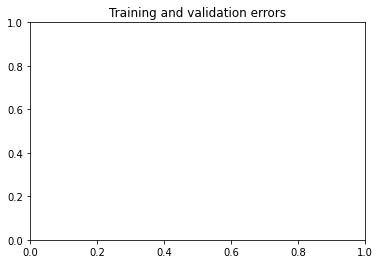

In [18]:
plt.title("Training and validation errors")
plt.plot(epoch, loss, color="orange", label="Train")

plt.xlabel("Epoch")
plt.ylabel("Errors")
plt.legend()

In [ ]:
plt.title("Training error")
plt.plot(epoch, training_error, color="orange", label="Train")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()

In [ ]:
y_pred = np.argmax(model.predict(test_X),axis=1)
accuracy_score(test_y, y_pred)

2205/2205 [==============================] - 8s 3ms/step


0.8985515462456419

confusion matrix:
[[ 5421  4658]
 [ 2500 57979]]
classification report:
              precision    recall  f1-score   support

         0.0       0.68      0.54      0.60     10079
         1.0       0.93      0.96      0.94     60479

    accuracy                           0.90     70558
   macro avg       0.81      0.75      0.77     70558
weighted avg       0.89      0.90      0.89     70558



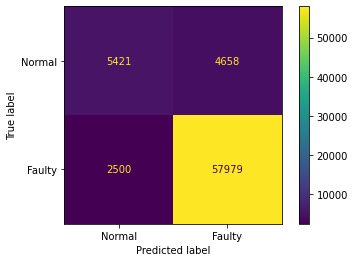

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_y, y_pred)
print('confusion matrix:')
print(cm)
#print('\n')
print('classification report:')
print(classification_report(test_y, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Faulty"])
disp.plot()

plt.show()

2205/2205 [==============================] - 3s 1ms/step


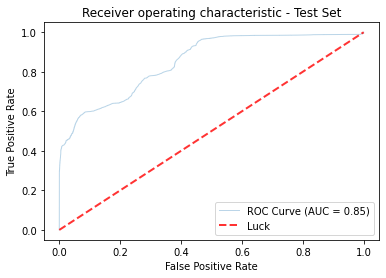

In [ ]:
def plot_roc_curve_lstm(model, X_test, Y_test):
    probas_ = model.predict(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC Curve (AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
plt.title('Receiver operating characteristic - Test Set')
plot_roc_curve_lstm(model,test_X,test_y)

In [ ]:
nnz_train = np.count_nonzero(y_pred) # class 1 population
nz_train = len(y_pred) - nnz_train # class 0 population
class_0_ratio = 100* (nz_train / len(y_pred))
class_1_ratio = 100* (nnz_train / len(y_pred))
print('%0.2f percent of test data belong to the negative class' % class_0_ratio)
print('%0.2f percent of test data belong to the positive class' % class_1_ratio)

# XGBoost

In [ ]:
trin = values[:n_train_hours, :-2]
panos = pd.DataFrame(trin)
panos.shape
panos["id"] = 0

In [ ]:
Train_Feat = tsfresh.extract_features(panos, column_id = "id", default_fc_parameters=MinimalFCParameters())

Feature Extraction: 100%|██████████| 14/14 [00:00<00:00, 246.80it/s]


In [ ]:
Train_Feat.shape

(1, 140)

In [ ]:
Train_Feat.head()

,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__root_mean_square,0__maximum,0__absolute_maximum,0__minimum,...,13__sum_values,13__median,13__mean,13__length,13__standard_deviation,13__variance,13__root_mean_square,13__maximum,13__absolute_maximum,13__minimum
0,66191.953125,0.337149,0.328331,201601.0,0.084288,0.007104,0.338978,1.0,1.0,0.0,...,98070.0,0.0,0.486456,201601.0,0.499816,0.249817,0.697464,1.0,1.0,0.0


In [ ]:
Train_Feat.isnull().values.any()

False

In [ ]:
tst = values[n_train_hours:, :-2]
panos2 = pd.DataFrame(trin)
panos2.shape
panos2["id"] = 0

In [ ]:
Test_Feat = tsfresh.extract_features(panos2, column_id = "id", default_fc_parameters=MinimalFCParameters())

Feature Extraction: 100%|██████████| 14/14 [00:00<00:00, 182.79it/s]


In [ ]:
Test_Feat.shape

(1, 140)

In [ ]:
Test_Feat.head()

,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__root_mean_square,0__maximum,0__absolute_maximum,0__minimum,...,13__sum_values,13__median,13__mean,13__length,13__standard_deviation,13__variance,13__root_mean_square,13__maximum,13__absolute_maximum,13__minimum
0,66191.953125,0.337149,0.328331,201601.0,0.084288,0.007104,0.338978,1.0,1.0,0.0,...,98070.0,0.0,0.486456,201601.0,0.499816,0.249817,0.697464,1.0,1.0,0.0


In [ ]:
train_y.shape

(201601,)

In [ ]:
train_y2 = train_y

In [ ]:
from xgboost import plot_importance
model = XGBClassifier()
model.fit(Train_Feat, train_y2)
# feature importance
_, ax = plt.subplots(figsize=(10, 20))
plot_importance(model, ax=ax)
plt.show()

XGBoostError: ignored